In [2]:
#dataset used UTKFace from kaggle  https://www.kaggle.com/datasets/jangedoo/utkface-new

#add predict code, also add droupout layers and batch normalization layer to improve model performance

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d jangedoo/utkface-new

100% 331M/331M [00:04<00:00, 95.7MB/s]
100% 331M/331M [00:04<00:00, 83.0MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/utkface-new.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import os
import numpy as numpy
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

In [6]:
folder_path = '/content/utkface_aligned_cropped/UTKFace'

In [7]:
age = []
gender = []
image_path = []

for file in os.listdir(folder_path):
  age.append(int(file.split('_')[0]))
  gender.append(int(file.split('_')[1]))
  image_path.append(file)

  

In [8]:
len(age)

23708

In [9]:
len(gender)

23708

In [10]:
df = pd.DataFrame({'age':age, 'gender':gender,'img':image_path})

In [11]:
df.shape

(23708, 3)

In [12]:
df.head()

,age,gender,img
0,30,1,30_1_0_20170117131108776.jpg.chip.jpg
1,26,1,26_1_2_20170116180302912.jpg.chip.jpg
2,28,1,28_1_3_20170119195104970.jpg.chip.jpg
3,35,1,35_1_0_20170103163357623.jpg.chip.jpg
4,34,1,34_1_1_20170113001823786.jpg.chip.jpg


In [13]:
train_df = df.sample(frac=1,random_state = 0).iloc[:20000]
test_df = df.sample(frac=1,random_state = 0).iloc[20000:]

In [14]:
train_df.shape

(20000, 3)

In [15]:
test_df.shape

(3708, 3)

In [16]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range = 30,
                                   width_shift_range=0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    directory = folder_path,
                                                    x_col = 'img',
                                                    y_col = ['age','gender'],
                                                    target_size = (200,200),
                                                    class_mode = 'multi_output')

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                    directory = folder_path,
                                                    x_col = 'img',
                                                    y_col = ['age','gender'],
                                                    target_size = (200,200),
                                                    class_mode = 'multi_output')

Found 20000 validated image filenames.
Found 3708 validated image filenames.


In [18]:
from keras.applications.vgg16 import VGG16
from keras.layers import *
from keras.models import Model

In [21]:
vggnet = VGG16(include_top = False, input_shape=(200,200,3))

58889256/58889256 [==============================] - 0s 0us/step


In [22]:
vggnet.trainable = False

In [23]:
output = vggnet.layers[-1].output
flatten = Flatten()(output)

dense1 = Dense(512, activation = 'relu')(flatten)
dense2 = Dense(512, activation = 'relu')(flatten)

dense3 = Dense(512,activation='relu')(dense1)
dense4 = Dense(512,activation='relu')(dense2)

output1 = Dense(1,activation='linear',name='age')(dense3)
output2 = Dense(1,activation='sigmoid',name='gender')(dense4)

In [30]:
model = Model(inputs = vggnet.input, outputs = [output1,output2])

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 200, 200, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 200, 200, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

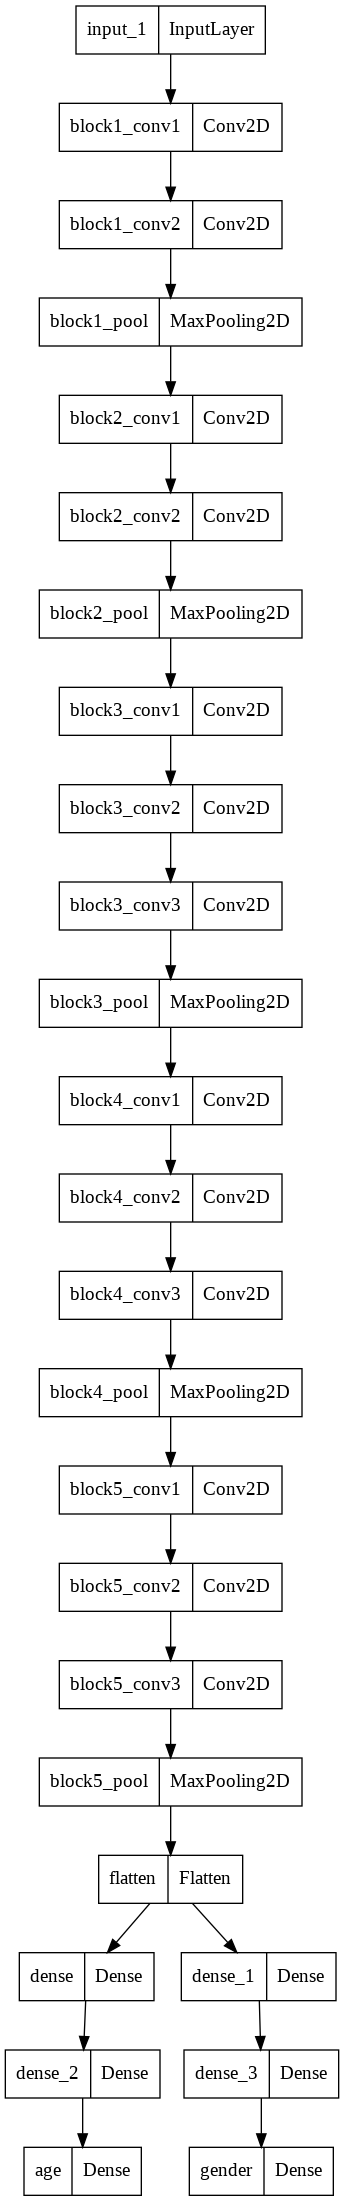

In [32]:
from keras.utils import plot_model
plot_model(model)

In [33]:
model.compile(optimizer='adam',loss = {'age':'mae','gender' : 'binary_crossentropy'},metrics = {'age':'mae','gender' : 'accuracy'},loss_weights = {'age':1,'gender' : 99})

In [36]:
history = model.fit(train_generator, batch_size = 32, epochs = 10, validation_data = test_generator)

Epoch 1/10
625/625 [==============================] - 205s 328ms/step - loss: 44.3310 - age_loss: 8.1451 - gender_loss: 0.3655 - age_mae: 8.1451 - gender_accuracy: 0.8312 - val_loss: 37.3656 - val_age_loss: 7.5029 - val_gender_loss: 0.3016 - val_age_mae: 7.5029 - val_gender_accuracy: 0.8689
Epoch 2/10
625/625 [==============================] - 205s 328ms/step - loss: 44.2497 - age_loss: 8.1132 - gender_loss: 0.3650 - age_mae: 8.1132 - gender_accuracy: 0.8327 - val_loss: 41.1982 - val_age_loss: 7.2198 - val_gender_loss: 0.3432 - val_age_mae: 7.2198 - val_gender_accuracy: 0.8476
Epoch 3/10
625/625 [==============================] - 207s 331ms/step - loss: 43.2433 - age_loss: 8.0002 - gender_loss: 0.3560 - age_mae: 8.0002 - gender_accuracy: 0.8368 - val_loss: 36.3746 - val_age_loss: 7.6939 - val_gender_loss: 0.2897 - val_age_mae: 7.6939 - val_gender_accuracy: 0.8716
Epoch 4/10
625/625 [==============================] - 205s 328ms/step - loss: 43.7482 - age_loss: 8.0170 - gender_loss: 0.36

In [37]:
import matplotlib.pyplot as plt

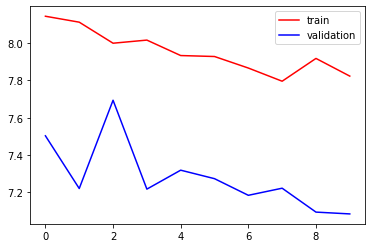

In [38]:
plt.plot(history.history['age_loss'],color = 'red',label ='train')
plt.plot(history.history['val_age_loss'],color = 'blue',label ='validation')
plt.legend()
plt.show()

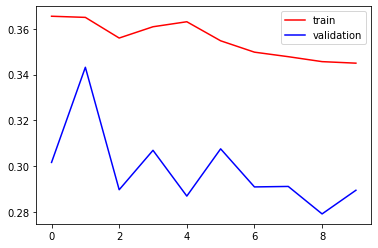

In [39]:
plt.plot(history.history['gender_loss'],color = 'red',label ='train')
plt.plot(history.history['val_gender_loss'],color = 'blue',label ='validation')
plt.legend()
plt.show()

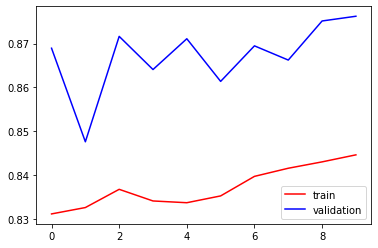

In [40]:
plt.plot(history.history['gender_accuracy'],color = 'red',label ='train')
plt.plot(history.history['val_gender_accuracy'],color = 'blue',label ='validation')
plt.legend()
plt.show()

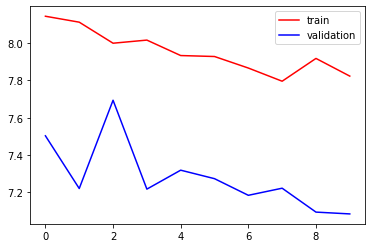

In [41]:
plt.plot(history.history['age_mae'],color = 'red',label ='train')
plt.plot(history.history['val_age_mae'],color = 'blue',label ='validation')
plt.legend()
plt.show()